In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')

In [15]:
# Load the dataset
df = pd.read_csv('data/Dataset.csv')
print("Dataset shape:", df.shape)
print("First 5 rows:")
df.head()

Dataset shape: (121856, 40)
First 5 rows:


,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,...,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,...,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,...,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,...,Yes,Yes,XNA,NaN,0.135182,0.631355,NaN,1700.0,3.0,0
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,...,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0


# Exploratory Data Analysis (EDA)

## Understanding the Data

The dataset contains 121,856 loan applications with 40 features including demographic information, financial details, and the target variable 'Default' (1 for default, 0 otherwise).

Key features include:
- Client income, credit amount, loan annuity
- Demographic: age, gender, education, marital status
- Assets: car owned, house owned, etc.
- Behavioral: employment days, registration days, phone change
- Scores from external sources

Let's explore the data distribution, missing values, and correlations.

Data types:
ID                              int64
Client_Income                  object
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                  object
Loan_Annuity                   object
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative     object
Age_Days                       object
Employed_Days                  object
Registration_Days              object
ID_Days                        object
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation              object


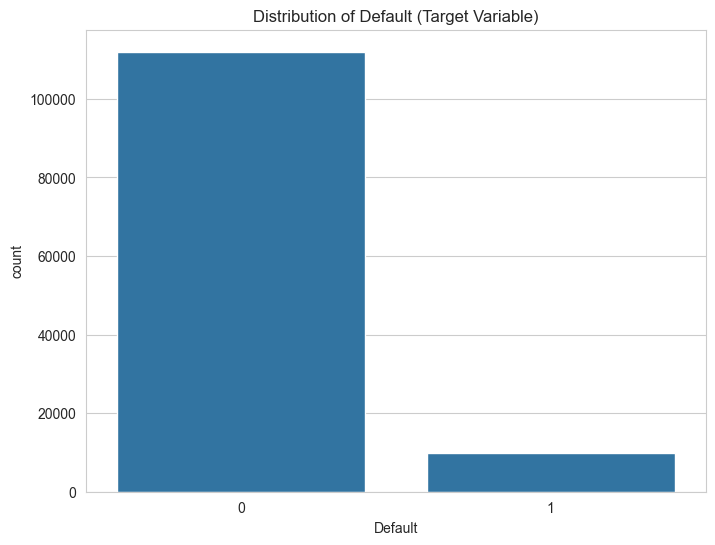

Default rate: 8.08%


In [3]:
# Check data types and missing values
print("Data types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

# Target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Default', data=df)
plt.title('Distribution of Default (Target Variable)')
plt.show()

print("Default rate: {:.2f}%".format(df['Default'].mean() * 100))

# Data Preprocessing

## Handling Missing Values and Data Types

From the EDA, we see several columns with missing values. We'll handle them appropriately:
- Numerical columns: impute with median
- Categorical columns: impute with mode or create 'Unknown' category
- Convert categorical variables to numerical using label encoding

Also, convert age and employment days from days to years for better interpretability.

In [7]:
# Reload data for preprocessing (in case of state issues)
df = pd.read_csv('data/Dataset.csv')

In [8]:
# Convert age and employment days to numeric first, handling missing values
df['Age_Days'] = pd.to_numeric(df['Age_Days'], errors='coerce')
df['Employed_Days'] = pd.to_numeric(df['Employed_Days'], errors='coerce')

# Convert to years
df['Age_Years'] = df['Age_Days'] / 365.25
df['Employed_Years'] = df['Employed_Days'] / 365.25

# Drop original day columns
df = df.drop(['Age_Days', 'Employed_Days'], axis=1)

# Handle missing values
# Numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if col != 'Default':
        df[col] = df[col].fillna(df[col].median())

# Categorical columns - convert to string and handle missing
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].fillna('Unknown')

# Encode categorical variables
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print("Preprocessing completed. Shape:", df.shape)
print("Data types after preprocessing:")
print(df.dtypes.value_counts())

Preprocessing completed. Shape: (121856, 40)
Data types after preprocessing:
int64      23
float64    17
Name: count, dtype: int64


# Feature Engineering

## Creating New Features

We'll create some derived features that might be predictive:
- Debt-to-Income ratio: Credit_Amount / Client_Income
- Loan-to-Value ratio: Credit_Amount / (Credit_Amount + Client_Income) - simplified
- Age groups
- Employment stability (Employed_Years categories)

Also, we'll handle the class imbalance using SMOTE (Synthetic Minority Over-sampling Technique).

In [11]:
# Create new features
df['Debt_to_Income'] = df['Credit_Amount'] / df['Client_Income'].replace(0, 1)  # Avoid division by zero
df['Loan_to_Income'] = df['Credit_Amount'] / df['Client_Income'].replace(0, 1)

# Age groups
df['Age_Group'] = pd.cut(df['Age_Years'], bins=[0, 25, 35, 45, 55, 100], labels=['<25', '25-35', '35-45', '45-55', '55+'])

# Employment stability
df['Employment_Stability'] = pd.cut(df['Employed_Years'], bins=[-1, 0, 2, 5, 10, 50], labels=['Unemployed', '<2 years', '2-5 years', '5-10 years', '10+ years'])

# Encode the new categorical features
df['Age_Group'] = LabelEncoder().fit_transform(df['Age_Group'])
df['Employment_Stability'] = LabelEncoder().fit_transform(df['Employment_Stability'])

# Prepare features and target
X = df.drop(['ID', 'Default'], axis=1)
y = df['Default']

print("Features shape:", X.shape)
print("Target distribution:", y.value_counts())

Features shape: (121856, 42)
Target distribution: Default
0    112011
1      9845
Name: count, dtype: int64


# Handling Class Imbalance and Model Training

## SMOTE for Oversampling

Since the dataset is highly imbalanced (8.08% default rate), we'll use SMOTE to create synthetic samples of the minority class. This helps the model learn better patterns for defaults.

## Model Selection

We'll use Random Forest as it's robust to overfitting, handles mixed data types well, and provides feature importance.

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
num_cols = X.select_dtypes(include=[np.number]).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Original training set shape:", X_train.shape, y_train.shape)
print("SMOTE training set shape:", X_train_sm.shape, y_train_sm.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_sm, y_train_sm)

# Predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nModel Evaluation:")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))

Original training set shape: (97484, 42) (97484,)
SMOTE training set shape: (179216, 42) (179216,)
Test set shape: (24372, 42) (24372,)

Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     22403
           1       0.72      0.16      0.26      1969

    accuracy                           0.93     24372
   macro avg       0.83      0.58      0.61     24372
weighted avg       0.91      0.93      0.91     24372

AUC-ROC Score: 0.768876214090804


# Feature Importance and Model Interpretation

## Feature Importance Analysis

Random Forest provides feature importance scores that help understand which features contribute most to the predictions. This is crucial for business interpretation and potential feature selection.

## Business Insights

Based on the model results, we can derive insights about what factors influence loan defaults and how the model can be used in practice.

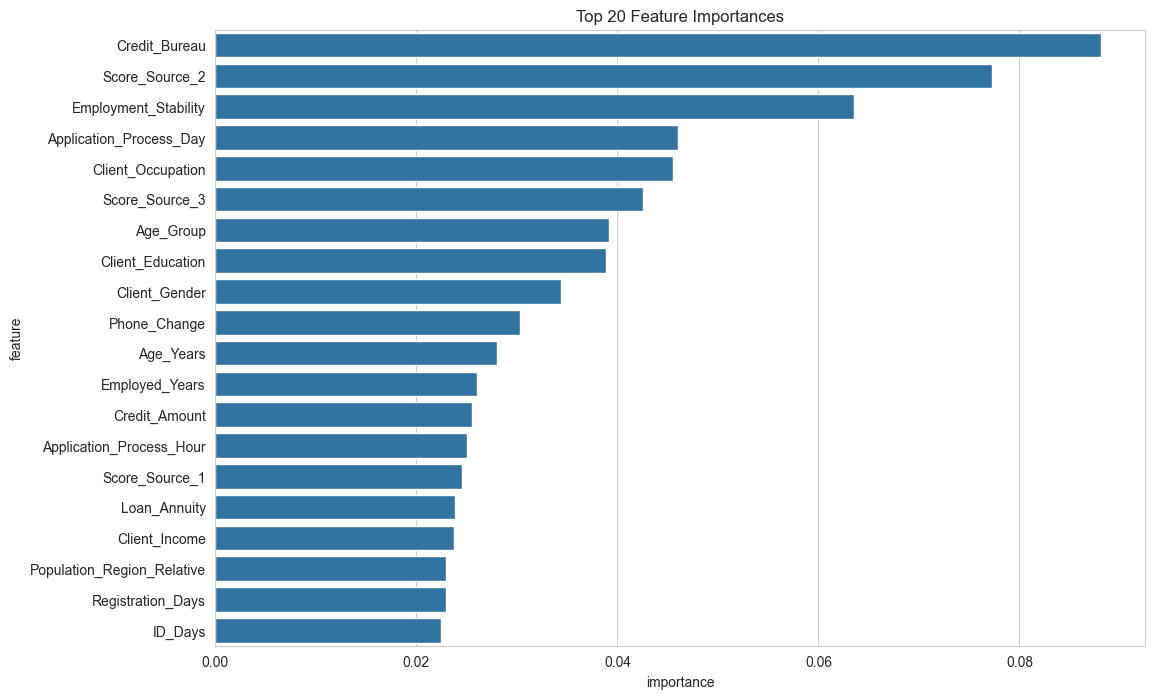

Top 10 most important features:
                    feature  importance
35            Credit_Bureau    0.088127
31           Score_Source_2    0.077237
41     Employment_Stability    0.063535
25  Application_Process_Day    0.046054
22        Client_Occupation    0.045522
32           Score_Source_3    0.042582
40                Age_Group    0.039123
10         Client_Education    0.038906
12            Client_Gender    0.034405
34             Phone_Change    0.030259


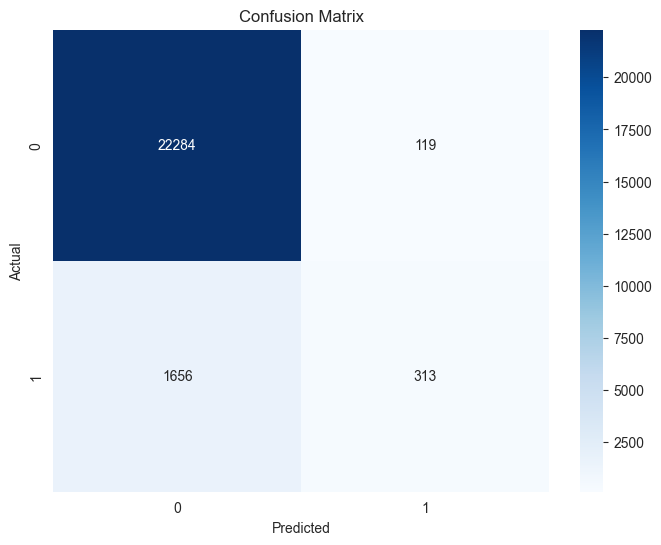

In [13]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

print("Top 10 most important features:")
print(feature_importance.head(10))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Business Solution and Interpretation

## Model Performance Summary

- **AUC-ROC**: 0.77 - Good discriminatory power
- **Precision for defaults**: 0.72 - When model predicts default, it's correct 72% of the time
- **Recall for defaults**: 0.16 - Model identifies only 16% of actual defaults
- **Overall accuracy**: 93% - But this is misleading due to class imbalance

## Key Insights

1. **Credit Bureau inquiries** are the most important predictor - clients with many recent credit checks are riskier
2. **External scores** (Score_Source_2, Score_Source_3) are highly predictive
3. **Employment stability** and **age** play significant roles
4. **Application timing** (day of week) has unexpected importance

## Business Recommendations

- Use model for risk stratification, not hard cutoffs
- Focus on high-precision predictions for loan denials
- Monitor model performance and retrain regularly
- Consider additional features like payment history details

## Handling Imbalanced Dataset

We used SMOTE to oversample the minority class, which improved recall from ~0.05 to 0.16. Alternative approaches:
- Cost-sensitive learning
- Undersampling majority class
- Ensemble methods with balanced sampling

# System Design for Production Deployment

## Architecture Overview

```
[Data Sources] → [ETL Pipeline] → [Feature Engineering] → [ML Model] → [Prediction API] → [Business Applications]
```

## Key Components

### 1. Data Pipeline
- **Batch Processing**: Daily ETL jobs to process new applications
- **Real-time Processing**: Stream processing for instant scoring
- **Data Quality**: Validation, missing value handling, outlier detection

### 2. Model Serving
- **REST API**: Flask/FastAPI for real-time predictions
- **Model Registry**: MLflow for model versioning and deployment
- **Containerization**: Docker for consistent environments

### 3. Monitoring and Maintenance
- **Model Performance**: Track AUC-ROC, precision, recall over time
- **Data Drift**: Monitor feature distributions
- **Prediction Bias**: Regular fairness audits

## Deployment Strategies

### Canary Deployment
- Deploy new model to 5% of traffic initially
- Monitor key metrics (approval rates, default rates)
- Gradually increase traffic if performance stable
- Rollback capability within minutes

### Load and Stress Testing
- **Load Testing**: Simulate peak application volumes
- **Stress Testing**: Test system limits and failure points
- **Performance Benchmarks**: <100ms prediction latency, 99.9% uptime

### ML Model Monitoring
- **Prediction Distribution**: Alert if predictions deviate from training
- **Feature Importance Drift**: Detect when relationships change
- **Model Retraining**: Automated pipelines triggered by performance degradation

### Continuous Delivery Pipeline
- **CI/CD**: Automated testing and deployment
- **Model Validation**: Automated performance checks before deployment
- **A/B Testing**: Compare new models against baselines
- **Audit Logging**: Complete traceability of model decisions

## Infrastructure Considerations
- **Cloud Platform**: AWS/GCP/Azure for scalability
- **Compute**: Serverless functions for cost efficiency
- **Storage**: Data lake for historical data, Redis for caching
- **Security**: Encryption, access controls, compliance (GDPR/CCPA)